In [4]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

import os
import sys
import glob
import time
import numpy as np
import numpy.random as nr

from keras.preprocessing.image import load_img, img_to_array, array_to_img

from keras.models import Model
from keras.applications import vgg19

from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b

np.set_printoptions(precision=3, linewidth=120, suppress=True)

In [5]:
sys.path.append('../src')
from my_keras_utilities import get_available_gpus
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


Content image: (1, 400, 600, 3) -123.68 151.061
  Style image: (1, 400, 600, 3) -116.779 131.32


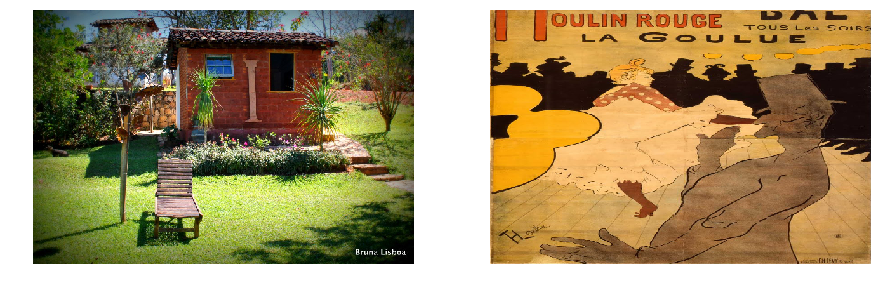

In [6]:
figdir = '../figures/style_transfer/'
resdir = figdir + 'results/'
os.makedirs(resdir, exist_ok=True)

image_file_path = figdir + 'museu_by_bruna.png'
image_file_path = figdir + 'lavras_novas__bruna.png'

style_file_path = figdir + 'tolouse-lautrec.png'

width, height = load_img(image_file_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(a):
    x = a.copy()
    x = x.reshape(img_nrows, img_ncols, 3)
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

vgg_image = preprocess_image(image_file_path)
vgg_style = preprocess_image(style_file_path)

print('Content image:', vgg_image.shape, vgg_image.min(), vgg_image.max())
print('  Style image:', vgg_style.shape, vgg_style.min(), vgg_style.max())

fig = plot.figure(figsize=(15, 7))
plot.subplot(1, 2, 1)
plot.imshow(deprocess_image(vgg_image[0]))
plot.axis('off')

plot.subplot(1, 2, 2)
plot.imshow(deprocess_image(vgg_style[0]))
plot.axis('off');


In [13]:
vgg = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=vgg_image.shape[1:])
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 600, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 150, 128)     0         
__________

In [14]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def compute_style_loss(output, target): 
    """this "style loss" is designed to maintain
    the style of the reference image in the generated image.
    It is based on the gram matrices (which capture style) of
    feature maps from the style reference image
    and from the generated image"""
    assert K.ndim(output) == 3
    assert K.ndim(target) == 3
    x_gram = gram_matrix(output)
    t_gram = gram_matrix(target)
    channels, size = 3, img_nrows * img_ncols
    return K.sum(K.square(x_gram - t_gram)) / (4.0 * (channels ** 2) * (size ** 2))

def compute_content_loss(output, target):
    """this "content loss" function is
    designed to maintain the "content" of the
    base image in the generated image"""
    return K.sum(K.square(output - target)) / 2.0


In [15]:
class Evaluator(object):
    def __init__(self, fun, shp): 
        self.funct = fun
        self.shape = shp
        
    def get_loss(self, x):
        self.loss, self.closs, self.sloss, self.grad_values = self.funct([x.reshape(self.shape)])
        return self.loss.astype(np.float64)

    def get_grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)

def my_solver(obj, niter, x, prefix):
    images = []
    try:
        for i in range(niter):
            t0 = time.time()
            x, min_val, info = fmin_l_bfgs_b(obj.get_loss, x.flatten(), fprime=obj.get_grads, maxfun=20)
            x = np.clip(x, -127, 127)
            dt = time.time() - t0
            print('{:2d}. loss: {:.3f}  [{:.3f} + {:.3f}] {:.3f}s'.format(i, min_val, obj.closs, obj.sloss, dt))
            imsave(resdir + prefix + '_at_iteration_{:02d}.png'.format(i), deprocess_image(x))
            images.append(x.copy())
    except KeyboardInterrupt:
        print('Interrupted!!')
    finally:
        return images  

In [31]:
def transfer_style(x, vgg_image, vgg_style, cwgt=1.0, niter=5, model=vgg, prefix='img'):
    K.clear_session()
    style_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_layer_name = 'block5_conv2'
    vgg_output_dict = {layer.name: layer.output for layer in model.layers}
    
#     image = K.variable(vgg_image)
#     style = K.variable(vgg_style)
#     artim = K.variable(input_image)
    
    style_outputs = [vgg_output_dict[ln] for ln in style_layer_names]
    style_model = Model(model.input, style_outputs)
    style_targets = [K.variable(o) for o in style_model.predict(vgg_style)]

    content_output = model.get_layer(content_layer_name).output
    content_model = Model(model.input, content_output)
    content_target = K.variable(content_model.predict(vgg_image))
    
    nsty = len(style_outputs) 
    style_weights = np.ones((nsty,)) / nsty

    content_loss = cwgt * compute_content_loss(content_output, content_target)
    style_loss = sum(w * compute_style_loss(out[0], targ[0]) for out, targ, w in zip(style_outputs, 
                                                                                     style_targets, 
                                                                                     style_weights))
    loss = content_loss + style_loss

    grads = K.gradients(loss, model.input)
    xfer_fn = K.function([model.input], [loss, content_loss, style_loss] + grads)
    evaluator = Evaluator(xfer_fn, image.shape)

    return my_solver(evaluator, niter, x, prefix)

In [32]:
niter = 5
x = np.random.uniform(-2.5, 2.5, vgg_image.shape)

In [33]:
A = transfer_style(vgg_image, vgg_image, vgg_style, cwgt=0.001,  niter=niter, prefix='i3')
B = transfer_style(vgg_image, vgg_image, vgg_style, cwgt=0.0001, niter=niter, prefix='i4')

fig = plot.figure(figsize=(15, 7))
plot.subplot(1, 2, 1)
plot.imshow(deprocess_image(A[-1]))
plot.axis('off')

plot.subplot(1, 2, 2)
plot.imshow(deprocess_image(B[-1]))
plot.axis('off');


ValueError: Tensor Tensor("block1_conv1/Relu:0", shape=(?, 400, 600, 64), dtype=float32) is not an element of this graph.

 0. loss: 520656.406  [502015.062 + 18641.332] 24.031s
 1. loss: 520605.250  [494856.812 + 25748.422] 23.564s
 2. loss: 499536.750  [481060.688 + 18476.066] 23.709s
 3. loss: 485594.844  [466647.688 + 18947.150] 23.844s
 4. loss: 474004.094  [455885.281 + 18118.811] 23.837s
 5. loss: 461991.594  [442407.688 + 19583.910] 24.079s
 6. loss: 454585.125  [435418.125 + 19166.994] 23.637s
 7. loss: 448057.969  [429067.031 + 18990.924] 23.977s
 8. loss: 442394.219  [422902.438 + 19491.791] 24.023s
 9. loss: 437707.562  [417914.594 + 19792.961] 23.688s
10. loss: 433380.125  [413762.031 + 19618.094] 23.946s
11. loss: 428996.719  [408778.219 + 20218.486] 23.941s
12. loss: 425729.156  [405931.031 + 19798.139] 23.939s
13. loss: 422024.500  [400839.781 + 21184.719] 23.955s
14. loss: 418734.062  [398494.031 + 20240.021] 23.900s
15. loss: 416047.000  [394737.125 + 21309.859] 23.774s
16. loss: 412837.312  [391539.844 + 21297.469] 23.941s
17. loss: 410491.969  [389118.844 + 21373.115] 23.549s
18. loss: 

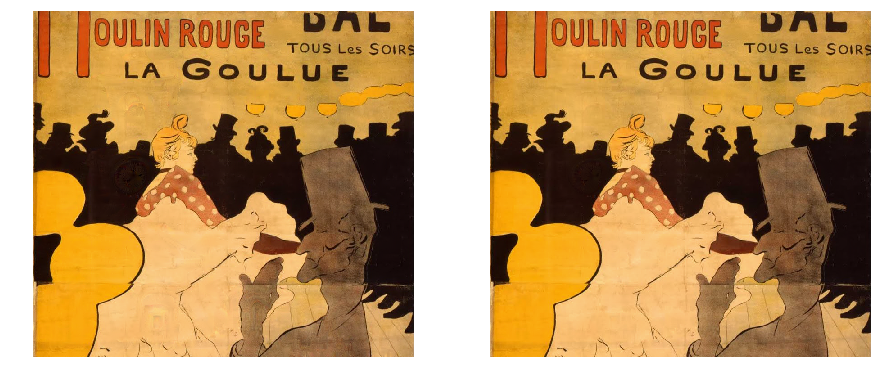

In [10]:
A = transfer_style(vgg_style, vgg_image, vgg_style, cwgt=0.001,  niter=niter, prefix='s3')
B = transfer_style(vgg_style, vgg_image, vgg_style, cwgt=0.0001, niter=niter, prefix='s4')

fig = plot.figure(figsize=(15, 7))
plot.subplot(1, 2, 1)
plot.imshow(deprocess_image(A[-1]))
plot.axis('off')

plot.subplot(1, 2, 2)
plot.imshow(deprocess_image(B[-1]))
plot.axis('off');


 0. loss: 6220123648.000  [486475.906 + 6219637248.000] 21.941s
 1. loss: 1448712192.000  [490777.844 + 1448221440.000] 23.003s
 2. loss: 627659456.000  [493664.156 + 627165760.000] 23.134s
 3. loss: 368818048.000  [502170.812 + 368315872.000] 23.344s
 4. loss: 248994112.000  [508918.125 + 248485200.000] 23.316s
 5. loss: 189400064.000  [512759.750 + 188887312.000] 23.366s
 6. loss: 153878144.000  [512374.000 + 153365776.000] 23.389s
 7. loss: 127620384.000  [510411.406 + 127109976.000] 23.652s
 8. loss: 109164720.000  [508994.844 + 108655728.000] 23.637s
 9. loss: 95072504.000  [507879.281 + 94564624.000] 23.683s
10. loss: 84623376.000  [506753.250 + 84116624.000] 23.639s
11. loss: 76306856.000  [506424.219 + 75800432.000] 23.574s
12. loss: 69882240.000  [506339.625 + 69375904.000] 23.569s
13. loss: 64694312.000  [506404.188 + 64187908.000] 23.590s
14. loss: 60431176.000  [506050.781 + 59925124.000] 23.655s
15. loss: 56434508.000  [504890.312 + 55929616.000] 23.730s
16. loss: 53049224

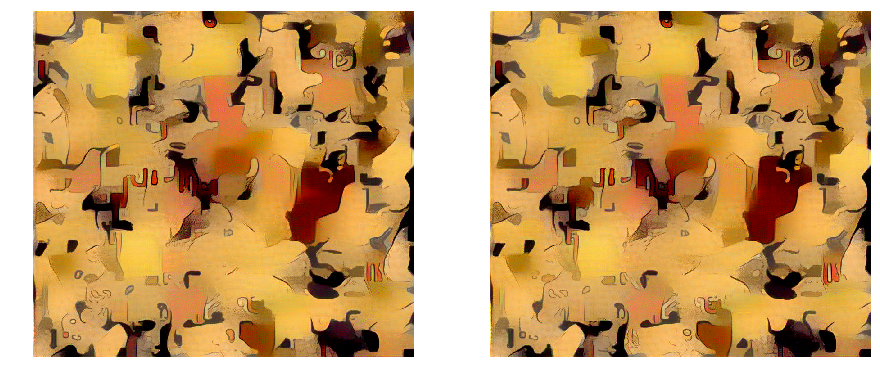

In [11]:
A = transfer_style(x, vgg_image, vgg_style, cwgt=0.001,  niter=niter, prefix='x3')
B = transfer_style(x, vgg_image, vgg_style, cwgt=0.0001, niter=niter, prefix='x4')

fig = plot.figure(figsize=(15, 7))
plot.subplot(1, 2, 1)
plot.imshow(deprocess_image(A[-1]))
plot.axis('off')

plot.subplot(1, 2, 2)
plot.imshow(deprocess_image(B[-1]))
plot.axis('off');
